 # Прогнозирование статуса студента

**Цель**: предсказать будущий
потенциальный статус студента на основе данных нескольких тысяч
студентов.

[Файл с описанием задачи и данных](Алтайский_край.pdf)

## Обзор данных

In [1]:
# импортируем некоторые питоновские модули
import os
import re
import time

# импортируем необходимые библиотеки и функции
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
from typing import Counter

# импортируем необходимые классы библиотеки lightautoml
from lightautoml.automl.presets.tabular_presets import (
    TabularUtilizedAutoML,
    TabularAutoML)
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore') 

# увеличиваем количество отображаемых столбцов и строк
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

%matplotlib inline

In [2]:
# зададим версию тетради решения
version = 'final'

In [3]:
# загрузим обучающую выборку
df = pd.read_csv(
    "data/train_dataset_train.csv", parse_dates=["Дата_Рождения"], index_col=0
)
df.head(3)

,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,Страна_ПП,Регион_ПП,Город_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
ID,,,,,,,,,,,,,,,,,,,,,,,
72716,16019,2015,Жен,ОО,Английский язык,1998-02-08,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
63306,14895,2010,Муж,ЦН,NaN,1992-04-18,NaN,NaN,NaN,0.0,Россия,Алтайский край,Барнаул г,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
82469,20103,2017,Жен,ДН,Английский язык,1999-03-21,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,0.0,Россия,Алтайский край,Алтайское с,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4


In [4]:
# загрузим тренировочную выборку
df_test = pd.read_csv(
    "data/test_dataset_test.csv", index_col=0, parse_dates=["Дата_Рождения"]
)
df_test.head(3)

,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,Пособие,Страна_ПП,Регион_ПП,Город_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата
ID,,,,,,,,,,,,,,,,,,,,,,
64996,20608,2014,Жен,ДН,Английский язык,1995-11-03,"МБОУ ""СОШ №55""","Алтайский край, Барнаул г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,40.0,49.0
71837,20613,2015,Жен,ДН,Немецкий язык,1995-12-10,"МБОУ ""СОШ №1""","Алтайский край, Рубцовск г",2014.0,0.0,Россия,Алтайский край,Барнаул г,0.0,0,0.0,Россия,0.0,1.0,0.0,26.0,77.0
86587,21210,2018,Жен,ОО,Английский язык,1973-08-09,Алтайский государственный медицинский университет,"Алтайский край, г. Барнаул",1997.0,0.0,Россия,Алтайский край,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,34.0,74.0


In [5]:
# размеры датафреймов
df_test.shape, df.shape

((6691, 22), (13584, 23))

In [6]:
# создадим список датафреймов
dfs = [df, df_test]

In [7]:
# приведем название признаков и
# значения текстовых признаков к нижнему регисру
for i in dfs:
    i.columns = [col.lower() for col in i.columns]
    for col in i.select_dtypes("object").columns:
        i[col] = i[col].str.lower()

In [8]:
# выведем информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13584 entries, 72716 to 80923
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   код_группы        13584 non-null  int64         
 1   год_поступления   13584 non-null  int64         
 2   пол               13577 non-null  object        
 3   основания         13584 non-null  object        
 4   изучаемый_язык    12758 non-null  object        
 5   дата_рождения     13584 non-null  datetime64[ns]
 6   уч_заведение      12351 non-null  object        
 7   где_находится_уз  12203 non-null  object        
 8   год_окончания_уз  12284 non-null  float64       
 9   пособие           12576 non-null  float64       
 10  страна_пп         13237 non-null  object        
 11  регион_пп         12966 non-null  object        
 12  город_пп          13141 non-null  object        
 13  общежитие         13498 non-null  float64       
 14  наличие_матери    

In [9]:
cat = [
    "основания",
    "изучаемый_язык",
    "страна_пп",
    "регион_пп",
    "город_пп",
    "страна_родители",
]

In [10]:
bin = [
    "пол",
    "пособие",
    "общежитие",
    "наличие_матери",
    "наличие_отца",
    "опекунство",
    "село",
    "иностранец",
]

In [11]:
con = [
    "србаллаттестата",
    "год_поступления",
    "год_окончания_уз",
    "код_группы",
    "кодфакультета",
]

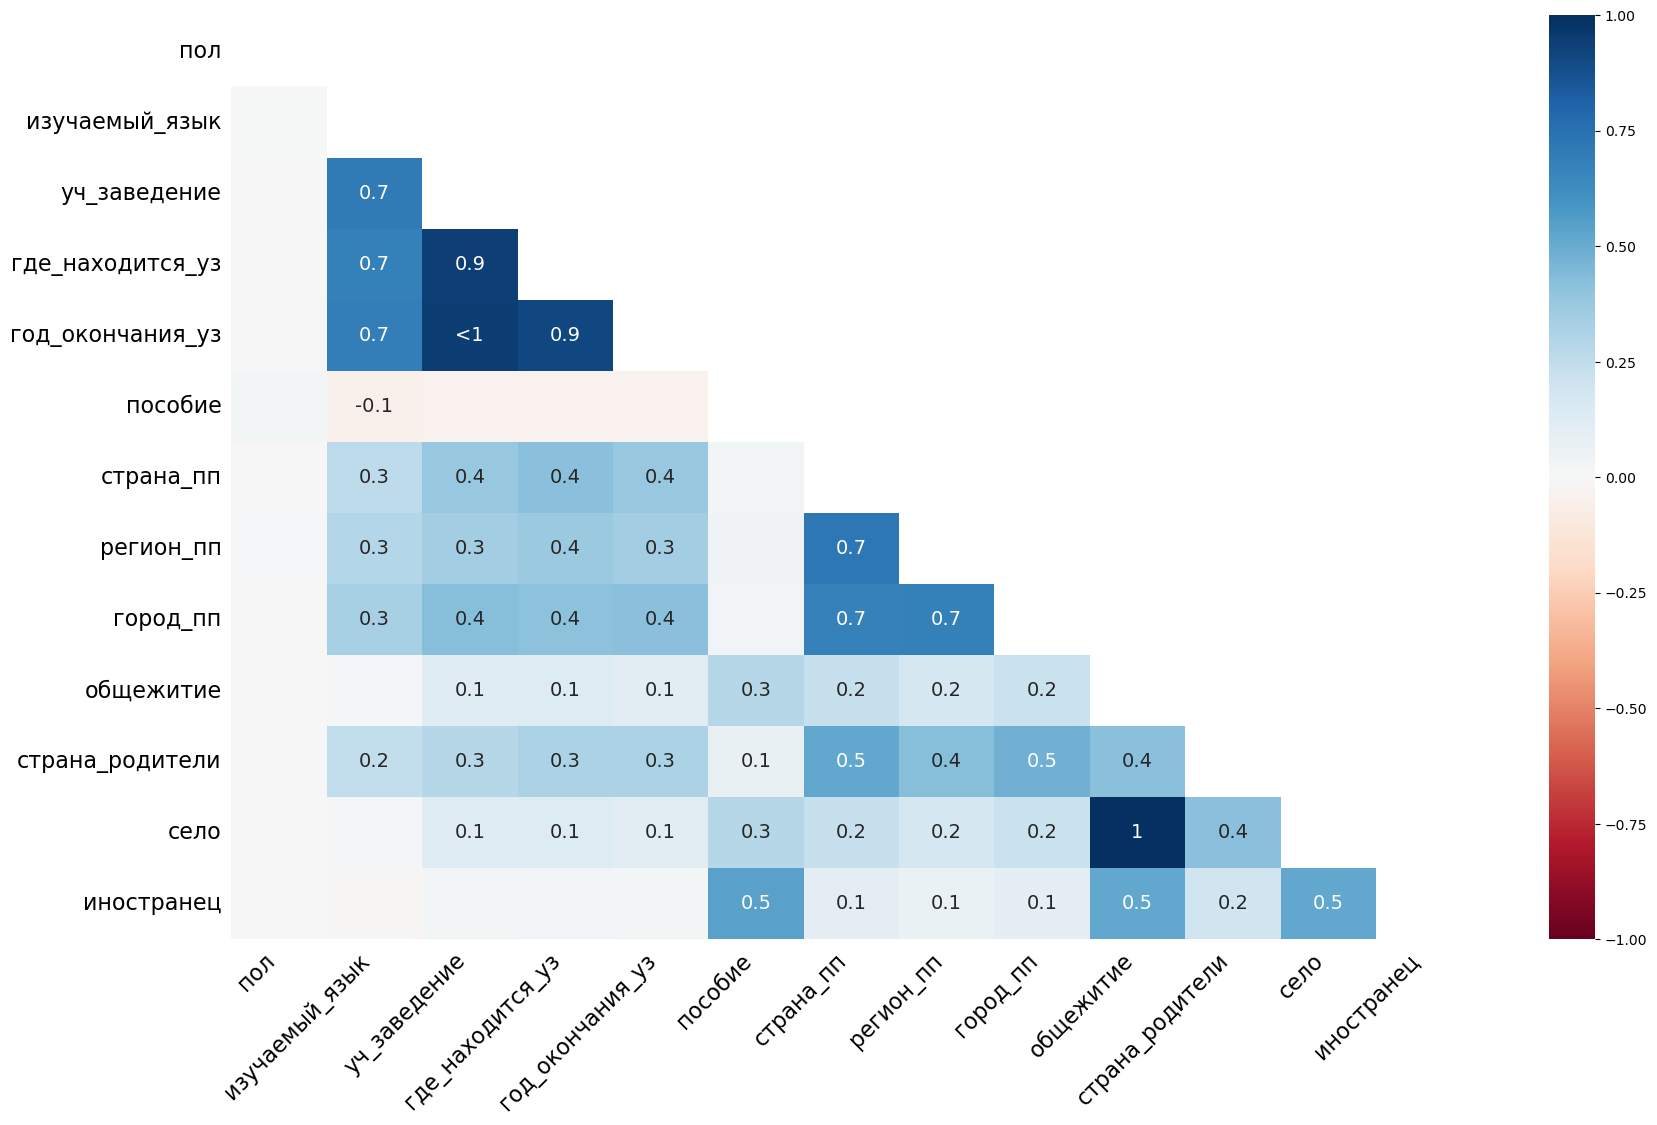

In [12]:
# построим корреляционную матрицу пропусков
msno.heatmap(df);

In [13]:
# рассчитаем доли пропусков
df.isna().mean()[df.isna().mean() != 0]

пол                 0.000515
изучаемый_язык      0.060807
уч_заведение        0.090769
где_находится_уз    0.101664
год_окончания_уз    0.095701
пособие             0.074205
страна_пп           0.025545
регион_пп           0.045495
город_пп            0.032612
общежитие           0.006331
страна_родители     0.033716
село                0.006331
иностранец          0.022821
dtype: float64

In [14]:
df.describe()

,код_группы,год_поступления,год_окончания_уз,пособие,общежитие,наличие_матери,наличие_отца,опекунство,село,иностранец,кодфакультета,србаллаттестата,статус
count,13584.000000,13584.000000,12284.000000,12576.0,13498.000000,13584.000000,13584.000000,13584.000000,13498.000000,13274.000000,13584.000000,13584.000000,13584.000000
mean,18302.499926,2014.992123,2013.876018,0.0,0.219884,0.511484,0.509570,0.000442,0.229441,0.070589,32.500368,73.223274,3.426458
std,2540.417956,2.595339,4.247111,0.0,0.414184,0.499886,0.499927,0.021013,0.420489,0.256147,8.458150,258.045027,1.071765
min,11550.000000,2001.000000,1973.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,-1.000000
25%,16901.000000,2013.000000,2013.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,47.000000,3.000000
50%,18534.500000,2015.000000,2015.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,28.000000,61.000000,4.000000
75%,20599.000000,2016.000000,2016.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,40.000000,75.000000,4.000000
max,22824.000000,2212.000000,2020.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,53.000000,5000.000000,4.000000


## Подготовка данных и конструирование признаков

In [15]:
# создадим признаки, отращающие статистики пропусков в каждом примере
for i in dfs:
    i["num_missing"] = i.isna().sum(axis=1)
    i["num_missing_std"] = i.isna().std(axis=1)

### Бинарные

In [16]:
# рассчитаем доли пропусков
df[bin].isna().mean()[df[bin].isna().mean() != 0]

пол           0.000515
пособие       0.074205
общежитие     0.006331
село          0.006331
иностранец    0.022821
dtype: float64

In [17]:
# заполним пропуски бинарных признаков
# выводы были сделаны при визуальном осмотре датасета
# с пропущенными значениями
# 'иностранец' - в примерах города РФ
# 'село' - многие из городов
# 'общежитие' - мноие из Барнаула
# 'пол' - пропущны жителями Китая, где женщины часто не указывают пол
for i in dfs:
    i["иностранец"] = i["иностранец"].fillna(0)
    i["село"] = i["село"].fillna(0)
    i["общежитие"] = i["общежитие"].fillna(0)
    i["пособие"] = i["пособие"].fillna(1)
    i["пол"] = i["пол"].map({"муж": 0, "жен": 1}).fillna(1)

In [18]:
# расчитаем признак social_tension как сумму бинарных признаков
for i in dfs:
    i["social_tension"] = i[bin].sum(axis=1)

### Непрерывные

In [19]:
df[con].describe()

,србаллаттестата,год_поступления,год_окончания_уз,код_группы,кодфакультета
count,13584.000000,13584.000000,12284.000000,13584.000000,13584.000000
mean,73.223274,2014.992123,2013.876018,18302.499926,32.500368
std,258.045027,2.595339,4.247111,2540.417956,8.458150
min,0.000000,2001.000000,1973.000000,11550.000000,24.000000
25%,47.000000,2013.000000,2013.000000,16901.000000,26.000000
50%,61.000000,2015.000000,2015.000000,18534.500000,28.000000
75%,75.000000,2016.000000,2016.000000,20599.000000,40.000000
max,5000.000000,2212.000000,2020.000000,22824.000000,53.000000


#### год_поступления

In [20]:
# выведем боттом 5 годов
df["год_поступления"].sort_values().tail()

ID
105404    2020
107634    2020
104973    2020
104894    2020
45077     2212
Name: год_поступления, dtype: int64

In [21]:
# исправим опечатку
df.loc[45077, "год_поступления"] = 2012

#### год_окончания_уз

<AxesSubplot:>

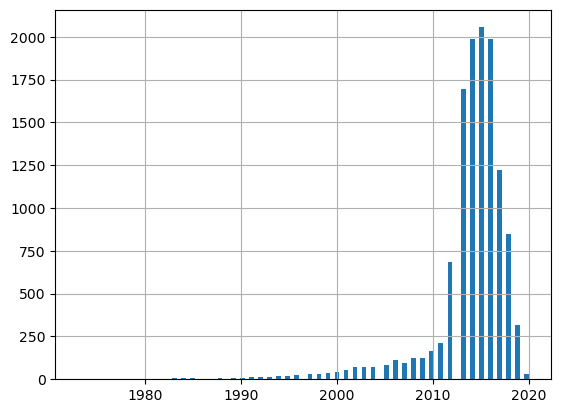

In [22]:
df["год_окончания_уз"].hist(bins=100)

#### год_окончания_уз

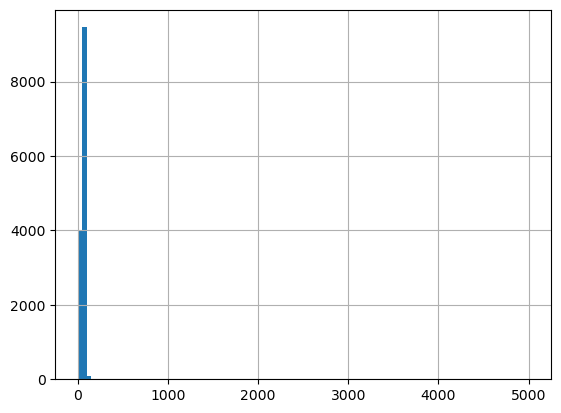

In [23]:
# построим гистограмму
df["србаллаттестата"].hist(bins=100)

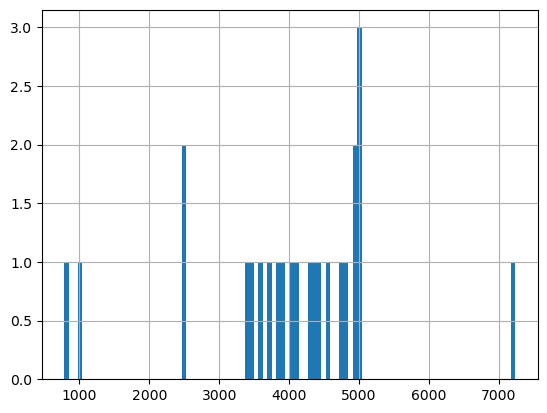

In [24]:
# построим гистограмму после значения 100
df_test[(df_test["србаллаттестата"] > 100)]["србаллаттестата"].hist(bins=100)

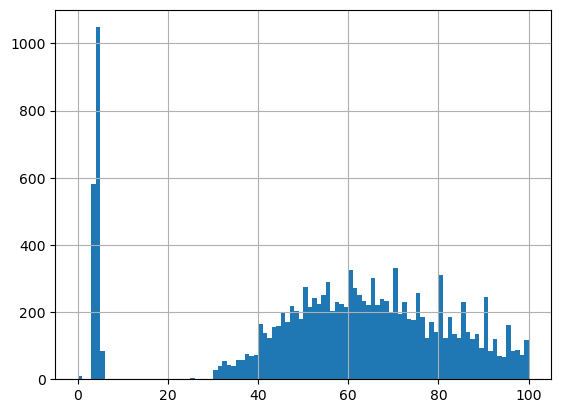

In [25]:
# построим гистограмму до знаечния 150
df[df["србаллаттестата"] < 150]["србаллаттестата"].hist(bins=100)

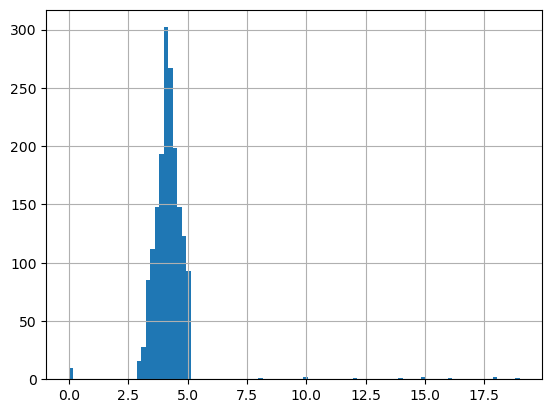

In [26]:
# построим гистограмму до знаечния 20
df[df["србаллаттестата"] < 20]["србаллаттестата"].hist(bins=100)

In [27]:
# в этом признаке определяются 3 распределения
# масштабируем их на 100-бальную шкалу и
# и создадим индикаторы этих распределений
for i in dfs:
    i["аттестат_флаг"] = 0
    i["аттестат_флаг"] = i["аттестат_флаг"].where(i["србаллаттестата"] > 5, 1)
    i["србаллаттестата"] = i["србаллаттестата"].where(
        i["србаллаттестата"] > 5, i["србаллаттестата"] * 20
    )

    i["тысячи_флаг"] = 0
    i["тысячи_флаг"] = i["тысячи_флаг"].where(i["србаллаттестата"] < 200, 1)
    i["србаллаттестата"] = i["србаллаттестата"].where(
        i["србаллаттестата"] < 200, i["србаллаттестата"] / 1000 * 20
    )

    i["балл_класс"] = 0
    i.loc[i["аттестат_флаг"] == 1, "балл_класс"] = 1
    i.loc[i["тысячи_флаг"] == 1, "балл_класс"] = 2

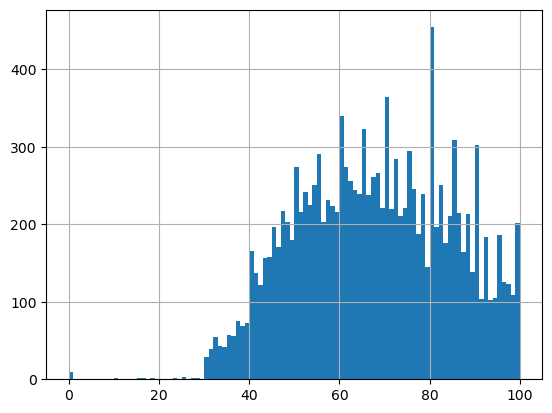

In [28]:
df["србаллаттестата"].hist(bins=100)

#### год_окончания_уз

In [29]:
# заполним пропуски годом поступления
for i in dfs:
    i["год_окончания_уз"] = i["год_окончания_уз"].fillna(i["год_поступления"])
    i["год_окончания_уз"] = i["год_окончания_уз"].astype(int)

#### год_поступления

In [30]:
# функция для построения баланса таргета по группам
def plot_proportion(cat_feature):
    g1 = df.groupby(["статус", cat_feature]).size().to_frame().unstack(fill_value=0)
    g1.columns = g1.columns.get_level_values(1)
    g1_sum_by_col = g1.div(g1.sum(axis=0), axis=1) * 100
    g1_sum_by_col.T.plot(kind="bar", stacked=False, sort_columns=True)
    pass

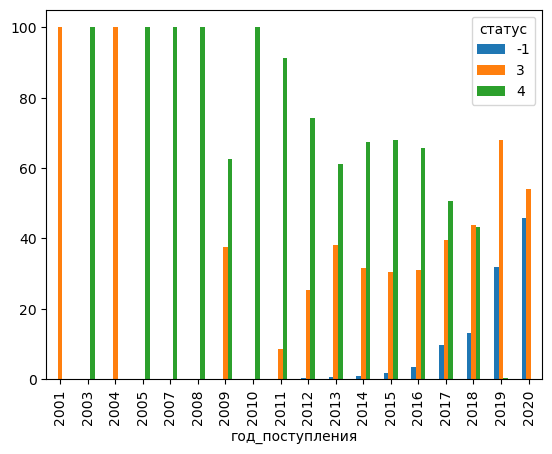

In [31]:
# построим баланс таргета по году поступления
plot_proportion("год_поступления")

In [32]:
# заметно, что отчистенные начинают значительно появлятся для
# студентов 2015 года обучения
# это может быть связано с заюолеваемостью ковидом
# создадим индикатор ковида
for i in dfs:
    i["covid"] = 0
    i["covid"] = i["covid"].where(i["год_поступления"] < 2015, 1)

In [33]:
# рассчитаем признаки
# 'возраст_поступления', 'возраст_окончания', 'задержка_поступления'
for i in dfs:
    i["возраст_поступления"] = i["год_поступления"] - i["дата_рождения"].dt.year
    i["возраст_окончания"] = i["год_окончания_уз"] - i["дата_рождения"].dt.year
    i["задержка_поступления"] = i["год_поступления"] - i["год_окончания_уз"]

### Категориальные

In [34]:
df[cat].describe(include="all")

,основания,изучаемый_язык,страна_пп,регион_пп,город_пп,страна_родители
count,13584,12758,13237,12966,13141,13126
unique,5,7,21,186,1744,18
top,оо,английский язык,россия,алтайский край,барнаул г,россия
freq,5084,10450,12472,11494,3735,12239


#### код_группы

In [35]:
# изменим тип данных признака
for i in dfs:
    i["код_группы"] = i["код_группы"].astype("int64").astype("object")

#### основания

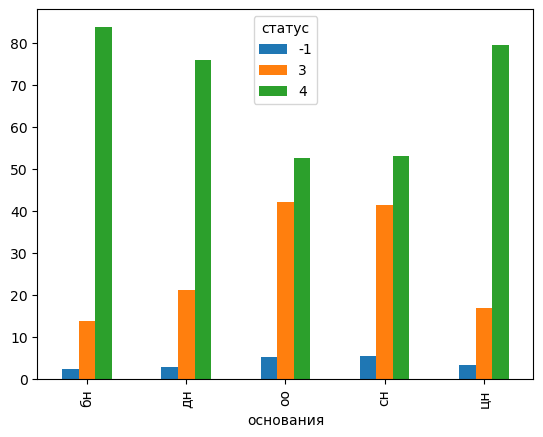

In [36]:
plot_proportion("основания")

In [37]:
# разделим на 2 группы на основании вышепостроенного распределения
# в группах оо и сн большая доля отчисленных
for i in dfs:
    i["оо+сн"] = 1
    cond = i["основания"].isin(["оо", "сн"])
    i["оо+сн"] = i["оо+сн"].where(cond, 0)
df["оо+сн"].value_counts()

1    9642
0    3942
Name: оо+сн, dtype: int64

#### изучаемый_язык

In [38]:
df["изучаемый_язык"].value_counts(dropna=False)

английский язык                  10450
немецкий язык                     2219
NaN                                826
французский язык                    54
русский язык                        11
иностранный язык (английский)       10
англиийский                         10
иностранный язык (немецкий)          4
Name: изучаемый_язык, dtype: int64

In [39]:
df_test["изучаемый_язык"].value_counts(dropna=False)

английский язык                  5202
немецкий язык                    1047
NaN                               396
французский язык                   28
англиийский                         8
иностранный язык (английский)       8
русский язык                        1
английский, немецкий языки          1
Name: изучаемый_язык, dtype: int64

In [40]:
# напишем функцию для очистки языков
def clear_lang(text):
    languages = {"английский", "немецкий", "французский", "русский"}
    text = str(text)
    if text != "nan":
        a = re.sub(r"[^а-яА-ЯёЁ ]", " ", text)
        a = a.replace("англиийский", "английский")
        a = a.replace("  ", " ").strip().split(" ")
        a = list(set(a) & languages)[0]
        return a
    return np.NaN

In [41]:
# очистим языки и заполним английским как самым популярным
for i in dfs:
    i["изучаемый_язык"] = (
        i["изучаемый_язык"].apply(lambda x: clear_lang(x)).fillna("английский")
    )

In [42]:
df["изучаемый_язык"].value_counts(dropna=False)

английский     11296
немецкий        2223
французский       54
русский           11
Name: изучаемый_язык, dtype: int64

In [43]:
df_test["изучаемый_язык"].value_counts(dropna=False)

английский     5615
немецкий       1047
французский      28
русский           1
Name: изучаемый_язык, dtype: int64

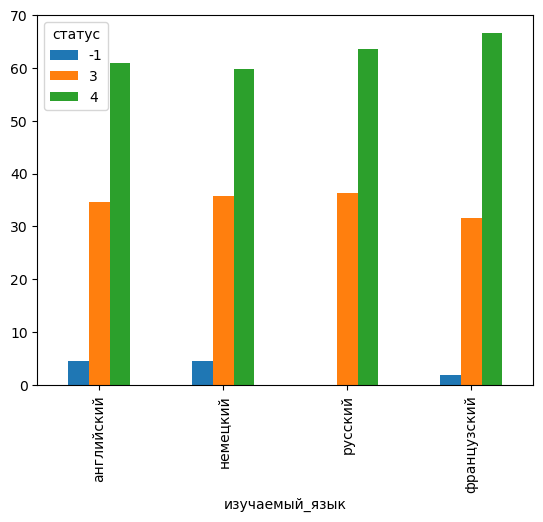

In [44]:
# балансы не различаются. В русском слишком мало представителей
plot_proportion("изучаемый_язык")

#### уч_заведение

In [45]:
df["уч_заведение"].nunique(), sorted(df["уч_заведение"].astype(str).unique())

(3610,
 ['nan',
  'автономная некоммерческая обр-ная орг-ция во "ааэип"',
  'автономная некоммерческая организация впо "алтайская академия экономики и права (институт)',
  'автономная некоммерческая организация впо "алтайская академия экономики и права (институт)"',
  'автономное учреждение респ саха (якутия) "алданский политехнический техникум"',
  'агау',
  'агролицей №60',
  'агу спо',
  'академический лицей при ташкентском государственном педагогическом университете им. низами',
  'академический лицей №4',
  'академия безансона',
  'академия мвд кыргызской республики им. генерал-майора милиции э.а. алиева',
  'академия труда и социальных отношений',
  'акмолинский финансово-экономический колледж',
  'акпл',
  'аламединская средняя школа №1',
  'алматинская академия экономики и статистики',
  'алматинская государственная консерватория им. курмангазы',
  'алматинский государственный театрально-художественный институт им. т.жургенова',
  'алматинский институт экономики и статистики',


In [46]:
# выведем популярные слова в названиях учреждений
cnt = Counter()
schools = " ".join(df["уч_заведение"].astype(str).tolist()).split()
for word in schools:
    cnt[word] += 1
pd.DataFrame.from_dict(
    cnt,
    orient="index",
    columns=["cnt"],
).sort_values(by="cnt", ascending=False).T

,мбоу,государственный,фгбоу,университет,алтайский,впо,сош,во,"""алтайский","университет""",nan,"""сош",им.,"сош""","""гимназия",мкоу,"""лицей",лицей,спо,кгбоу,гимназия,и,г.,педагогический,с,технический,кгу,гоу,колледж,изучением,школа,академия,и.и.,углубленным,отдельных,"колледж""","№1""",средняя,№1,моу,кгбпоу,№,ползунова,барнаульский,"предметов""","№2""",институт,техникум,алтайского,"""барнаульский",героя,"""алтайская",аграрный,№2,советского,общеобразовательная,алтайская,союза,"№3""",предметов,государственная,"ползунова""",№3,экономики,кгб,лицей-интернат,промышленно-экономический,поу,сш,российской,училище,фгоу,образования,при,народного,краевой,края,нпо,школа-интернат,ноу,в.е.,медицинский,№27,федерации,№130,района,в.м.,права,им,кгбо,"""бийский",№5,"№42""","№4""",бийский,№125,государственной,службы,"№5""",горно-алтайский,имени,№4,фбгоу,с.,"лицей""","""средняя",города,бийск,политехнический,"№22""",культуры,школа-гимназия,"№112""",гу,хозяйства,№89,учреждение,маоу,президенте,"№123""","№69""","""горно-алтайский",городского,кгоу,"техникум""",№40,сибирский,№6,"академия""",российская,округа,аноо,"""раэпш""",камень-на-оби,"№124""","школа""",педагогическая,№42,смирнова,"№101""",№128,национальный,боу,кооперативный,"шукшина""",соу,№12,ано,№17,№8,восточно-казахстанский,"№85""",государственное,зато,"№86""",информатики,№22,"№127""","""сигма""","№8""","""белокурихинская",ю.а.,архитектурно-строительный,№112,"""профессиональное","смирнова""","""",№7,ссср,р-на,№15,новосибирский,№124,№10,"№74""",сельскохозяйственный,"№126""",учителя,технологий,овсиевской,"""общеобразовательная",№9,"№10""",новоалтайск,гостеприимства,республики,уезда,"№19""",управления,№127,"№9""","""первомайская",технологический,"№129""",№126,кадетский,образовательное,"№80""","экономики,",н.а.,шукшина,"""сош""",№69,"""профессиональный",министерства,рубцовск,"""поспелихинская","№102""",юридический,искусств,"№7""","№73""","№11""",исследовательский,внутренних,заринск,"№6""",кадетская,статистики,строительный,фгкоу,№114,"№79""",сергея,№101,"островского""",сигма,"""павловский",фгаоу,томский,дел,№122,а.в.,экономический,"№40""","и.и.ползунова""",белокурихинская,торгово-экономический,"края""",1,"федерации""",сибирского,№20,павлодарский,руфины,"лицей-интернат""",№123,общеобразовательное,"""московский","права""",осш,чоу,профессиональное,27-й,гагарина,для,№129,№19,батальона,базовый,стрелковой,"""кулундинская",дивизии,"№55""",таджикский,"№17""",классический,раэпш,крайпотребсоюза,"№12""",правительстве,аманжолова,"№45""",алтгу,"""бригантина""","""тальменская","""славгородский",барнаул,№74,"№13""",№38,"№117""",(сменная),"""рубцовский",тальменская,финансово-экономический,№79,"№121""",бюджетное,сервиса,музыки,№113,"крайпотребсоюза""",№86,рф,шипуновская,муниципальное,г,е.е.,"№103""",профессионального,"№18""","""волчихинская","№76""",№31,№80,экономико-юридический,павлюкова,музыкальный,"№107""","""мамонтовская",корпус,№18,"№110""","""сш","№122""",россии,№29,и.з.,"№27""",провинции,№45,гуманитарный,№132,путей,кгкп,№85,"""школа-гимназия""",почу,№16,машиностроительный,"№14""",кемеровский,московский,(славянский),"""павловская",художественное,"гагарина""","""ключевская","""шипуновская",гбоу,"""пу",шемонаиха,дизайна,международный,"искусств""","№132""",высшего,летной,гуманитарная,"корпус""","""березовская",алтай,"(математики)""",№55,"""родинская","""романовская",подготовкой,"""кош-агачская",коммерции,"№131""",первоначальной,"""новосибирский","""лицей""",первомайская,"№37""","№68""",михайловский,"№15""","школа-лицей""","""экономическая",языков,№73,"№166""",№34,топчихинская,экспериментальная,школа-лицей,"""змеиногорская",№13,"(техникум)""","""новоалтайское",№121,бийска,пу,"рф""",кадетскими,"серафимовны""","""троицкая","""осш",осшг,бпоу,мсош,№120,"""республиканский",№76,№53,казахский,ключевская,"""каменский",гуманитарно-педагогический,рубцовский,"луначарского""",сыроделия,павловская,промышленных,"№75""","""староалейская",№59,семенова,"""чарышская",№11,мвд,усть-калманская,н.а.островского,по,"""залесовская",заочный

In [47]:
# подготовим переменные и датафрейм для выделения уровня образования
edu_level = {
    "среднее": [
        "сош",
        "школа",
        "лицей",
        "гимназия",
        "школа-лицей",
        "школа-гимназия",
        "сш",
        "осш",
        "лицей-интернат",
        "сш-гимназия",
        "школа-интернат",
        "школа-лицей-интернат",
        "соу",
        "осш-гимназия",
        "сош-лицей",
        "оош",
        "углубленным",
        "мбоу",
        "кгош-интернат",
        "общеобразовательное",
        "мсош",
        "ош",
    ],
    "среднее_спец": [
        "колледж",
        "техникум",
        "училище",
        "лесхоз-техникум",
        "профтехучилище",
        "спо",
        'колледж"',
        "колледжа",
    ],
    "высшее": [
        "университет",
        "институт",
        "академия",
        "впо",
        "высшего",
        "универститет",
        "гту",
        "фгбоу",
        "консерватория",
    ],
}

for level in edu_level.keys():
    df[f"{level}_флаг"] = 0
    df_test[f"{level}_флаг"] = 0

In [48]:
# функция выделения уровня образования
def edu(row):
    name = re.sub(r"[^а-яА-ЯёЁ ]", " ", str(row["уч_заведение"])).split()
    for key, values in edu_level.items():
        for value in values:
            if value in name:
                row[f"{key}_флаг"] = 1
    return row

In [49]:
# уберём кавычки и выделим уровни
for i in dfs:
    i["уч_заведение"] = (
        i["уч_заведение"].astype(str).apply(lambda x: x.replace('"', ""))
    )
    i = i.apply(edu, axis=1)

#### страна_пп

In [50]:
df["страна_пп"].value_counts()

россия                    12472
казахстан                   415
китай                       148
таджикистан                 118
кыргызстан                   32
киргизия                     21
казахстан респ                6
кыргызия                      6
росссия                       2
монголия                      2
кыргызская республика         2
таджикистан респ              2
туркменистан                  2
армения                       2
узбекистан                    1
нигерия                       1
франция                       1
казахстан вко                 1
республика казахстан          1
республика таджикистан        1
украина                       1
Name: страна_пп, dtype: int64

In [51]:
df["страна_пп"].value_counts()

россия                    12472
казахстан                   415
китай                       148
таджикистан                 118
кыргызстан                   32
киргизия                     21
казахстан респ                6
кыргызия                      6
росссия                       2
монголия                      2
кыргызская республика         2
таджикистан респ              2
туркменистан                  2
армения                       2
узбекистан                    1
нигерия                       1
франция                       1
казахстан вко                 1
республика казахстан          1
республика таджикистан        1
украина                       1
Name: страна_пп, dtype: int64

In [52]:
# функция очистки стран
def clear_country(text):
    trash = ["республика", "респ", "респ", "вко"]
    kirg = ["кыргызстан", "кыргызская", "кыргызия"]
    text = str(text)
    if text != "nan":
        a = re.sub(r"[^а-яА-ЯёЁ ]", " ", text)
        for i in trash:
            a = a.replace(i, "")
        for i in kirg:
            a = a.replace(i, "киргизия")
        a = a.replace("кнр", "китай")
        a = a.replace("росссия", "россия")
        a = a.replace("чеченская", "россия")
        a = a.replace("  ", " ").strip()
        return a
    return np.NaN

In [53]:
# очистим названия стран и заменим на РФ как на частую
for i in dfs:
    i["страна_пп"] = i["страна_пп"].apply(clear_country).fillna("россия")

In [54]:
df["страна_пп"].value_counts(dropna=False)

россия          12821
казахстан         423
китай             148
таджикистан       121
киргизия           61
армения             2
туркменистан        2
монголия            2
нигерия             1
узбекистан          1
франция             1
украина             1
Name: страна_пп, dtype: int64

In [55]:
df_test["страна_пп"].value_counts(dropna=False)

россия          6321
казахстан        202
китай             82
таджикистан       42
киргизия          37
узбекистан         4
афганистан         1
монголия           1
туркменистан       1
Name: страна_пп, dtype: int64

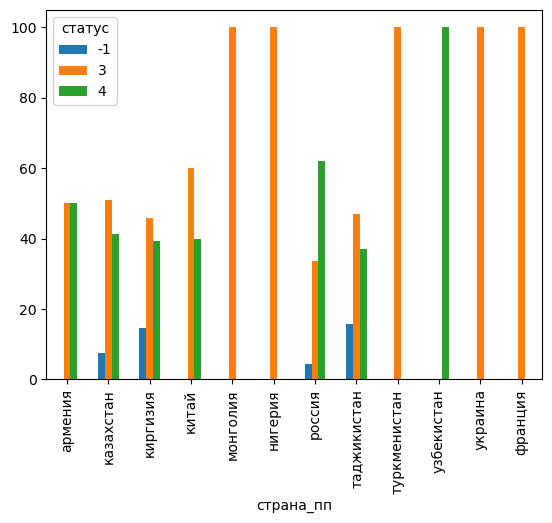

In [56]:
plot_proportion("страна_пп")

#### регион_пп

In [57]:
df["регион_пп"].unique()

array(['алтайский край', nan, 'восточно-казахстанская обл',
       'жалал-абадская обл', 'павлодарская обл', 'алтай респ',
       'восточно-казахстанская область', 'гуандун пров.',
       'провинция ляонин', 'пр.хэйлунцзян', 'республика алтай',
       'хатлонская обл', 'алайский край', 'алматинская обл',
       'южно-казахстанская область', 'хатлонская обл.',
       'ленинградская обл', 'акмолинская обл', 'кемеровская обл',
       'провинция синьцзян', 'свердловская обл', 'в-казахстанская обл',
       'краснодарский край', 'алматинская область', 'жалал-абадская',
       'в-казахстанская обл.', 'новосибирская область', 'чеченская респ',
       'республика тыва', 'тыва респ', 'сычуань', 'вко',
       'сахалинская область', 'новосибирская обл', 'пров. хэнань',
       'провинция хайнань', 'курганская область', 'алтаский край',
       'иссык-кульская', 'в-казахстанская область', 'кемеровская область',
       'республика крым', 'карагандинская обл',
       'республика саха /якутия/',
       

In [58]:
# функция очистки региона
def clear_region(text):
    trash = [
        "республика",
        "область",
        "провинция",
        "край",
        " края",
        "респ",
        "обл",
        "пров",
        "пр ",
        "ао ",
        " ао",
        " кра",
        " кр",
        "г ",
        "р-н",
    ]
    kirg = ["кыргызстан", "кыргызская", "кыргызия"]
    altaiskiy = [
        "алтайский   барнаул г",
        "алтайский ай",
        "алайский",
        "алтайский карй",
        "алтаский",
        "алтайский",
    ]
    kz = [
        "вко",
        "в-казахстанская",
        "восточно-казастанская",
        "восточно-кзахстанская",
        "восточно-казахстанская",
    ]
    text = str(text)
    if text != "nan":
        a = re.sub(r"[^а-яА-ЯёЁ -]", " ", text)
        a = a.replace(" - ", "-")

        for i in trash:
            a = a.replace(i, "")
        for i in kirg:
            a = a.replace(i, "киргизия")
        for i in kz:
            a = a.replace(i, "восточно-казахстан")
        a = a.replace("восточно-казахстан", "восточно-казахстанская")

        for i in altaiskiy:
            a = a.replace(i, "алтайски")
        a = a.replace("алтайски", "алтайский")
        a = a.replace("барнаул", "алтайский")
        a = a.replace("московкая", "московская")
        a = a.replace("москва г", "москва")
        a = a.replace("ляолин", "ляонин")
        a = a.replace("ысык-кульская", "иссык-кульская")
        a = a.replace("талас", "таласская")

        if "ханты" in text.split("-"):
            a = "ханты-мансийский"

        a = a.replace("  ", " ").strip()
        a = a.replace("  ", " ").strip()
        a = a.replace("  ", " ").strip()
        a = a.replace("  ", " ").strip()
        return a
    return np.NaN


In [59]:
# очистим регионы
for i in dfs:
    i["регион_пп"] = i["регион_пп"].apply(clear_region)

#### город_пп

In [60]:
df["город_пп"].nunique(), np.sort(df["город_пп"].astype(str).unique())

(1744,
 array([' ', '-', '10 лет октября с', ..., 'ярославль г', 'ясная поляна п',
        'ясная поляна с'], dtype=object))

In [61]:
# фуекция очистки города
def clear_city(text):
    trash = [
        " с.",
        "г.",
        "г",
        "город",
        "село",
        "гор",
        "округ",
        "дж",
        " джамоат",
        "р",
        "р-н",
        "а",
        "ст",
        "плотинная",
        "пос",
        "п",
        "с",
        "д" "пр",
        "рп",
        "пгт",
        "деревня",
    ]
    text = str(text)
    if text != "nan":
        a = re.sub(r"[^а-яА-ЯёЁ -]", " ", text)
        a = a.replace(" -", "-")
        a = a.replace("- ", "-")
        a = a.split()

        if len(a) == 1:
            a[0] = "nan"
        if len(a) == 0:
            a = ["nan"]
        for j in trash:
            if j in a:
                a.remove(j)
        if "барнаул" in a:
            a.clear()
            a.append("барнаул")
        if a[0] == "nan":
            return np.NaN
        return " ".join(a)
    return np.NaN

In [62]:
# очистим города
for i in dfs:
    i["город_пп"] = i["город_пп"].apply(clear_city)

In [63]:
df["город_пп"].nunique(), df_test["город_пп"].nunique()

(1034, 688)

#### страна_родители

In [64]:
df["страна_родители"].value_counts(dropna=False)

россия                    12239
казахстан                   515
NaN                         458
китай                       147
таджикистан                 133
кыргызстан                   37
киргизия                     31
туркменистан                  5
армения                       3
узбекистан                    3
кыргызская республика         3
республика таджикистан        2
монголия                      2
республика молдова            1
нигерия                       1
германия                      1
республика казахстан          1
украина                       1
кнр                           1
Name: страна_родители, dtype: int64

In [65]:
df_test["страна_родители"].value_counts()

россия                    6075
казахстан                  239
китай                       82
таджикистан                 45
кыргызстан                  24
киргизия                    14
кыргызская республика        3
узбекистан                   3
афганистан                   2
туркменистан                 2
монголия                     1
республика таджикистан       1
чеченская республика         1
кыргызия                     1
Name: страна_родители, dtype: int64

In [66]:
# очистим страны
for i in dfs:
    i["страна_родители"] = i["страна_родители"].apply(clear_country)

##### кодфакультета

In [67]:
# приведем к целочисленному типу
for i in dfs:
    i["кодфакультета"] = i["кодфакультета"].astype(int)

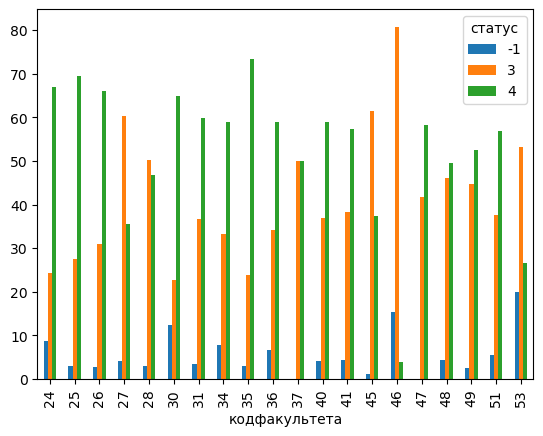

In [68]:
plot_proportion("кодфакультета")

## LAMA

In [69]:
# количество потоков
N_THREADS = 8
# количество блоков перекрестной проверки для AutoML
N_FOLDS = 5
# стартовое значение генератора
# псевдослучайных чисел
RANDOM_STATE = 42
# размер теста для оценки метрик
TEST_SIZE = 0.2
# время в секундах для выполнения AutoML
TIMEOUT = 600
# имя зависимой переменной
TARGET_NAME = "статус"

In [70]:
# для лучшей воспроизводимости фиксируем стартовое
# значение генератора псевдослучайных чисел
# и максимальное количество потоков для Torch
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [71]:
# загружаем исторический набор новых данных
train_data = df.copy()
train_data['статус'] = train_data['статус'].map({4:0, 3:1, -1:2})

In [72]:
# загружаем набор новых данных
test_data = df_test.copy()

In [73]:
# разбиваем данные на обучающую и тестовую выборки
tr_data, te_data = train_test_split(
    train_data,
    test_size=TEST_SIZE,
    stratify=train_data[TARGET_NAME],
    random_state=RANDOM_STATE,
)
print(
    "Разбиваем данные на части: обучающая = {}, тестовая = {}".format(
        train_data.shape, test_data.shape
    )
)

Разбиваем данные на части: обучающая = (13584, 37), тестовая = (6691, 36)


In [74]:
# задаем тип задачи, функцию потерь и метрику
task = Task(name="multiclass")

In [75]:
# обучим 1 итерацию для формирования отчёта
RD = ReportDeco(output_path="report")
automl_rd = RD(
    TabularAutoML(
        task=task,
        timeout=TIMEOUT,
        cpu_limit=N_THREADS,
        reader_params={
            "n_jobs": N_THREADS,
            "cv": N_FOLDS,
            "random_state": RANDOM_STATE,
        },
    )
)

In [76]:
# задаем роли переменных
roles = {"target": TARGET_NAME}

In [77]:
%%time
# обучим модель
oof_pred = automl_rd.fit_predict(tr_data, roles = roles, verbose = 1)

[22:57:07] Stdout logging level is INFO.
[22:57:07] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[22:57:07] Task: multiclass

[22:57:07] Start automl preset with listed constraints:
[22:57:07] - time: 600.00 seconds
[22:57:07] - CPU: 8 cores
[22:57:07] - memory: 16 GB

[22:57:08] Train data shape: (10867, 37)

[22:57:12] Layer 1 train process start. Time left 595.03 secs
[22:57:13] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[22:57:41] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.3946380267714461
[22:57:41] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:57:41] Time left 566.68 secs

[22:57:49] Selector_LightGBM fitting and predicting completed
[22:57:50] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[22:58:31] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.31036615534100637
[22:58:31] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:58:31] Start hyperparameters optimization f

In [78]:
# выгрузим отчёт
!ls tabularAutoML_model_report

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [79]:
# создаем модель AutoML - экземпляр класса TabularUtilizedAutoML
automl = TabularUtilizedAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    general_params={
        "nested_cv": False,
        "use_algos": [
            ["lgb", "lgb_tuned", "linear_l2", "cb", "cb_tuned"],
            ["lgb_tuned", "linear_l2"],
        ],
    },
    reader_params={"n_jobs": N_THREADS, "cv": N_FOLDS, "random_state": RANDOM_STATE},
)

In [80]:
%%time
# обучаем модель AutoML и получаем out-of-fold прогнозы
oof_pred = automl.fit_predict(tr_data, roles=roles, verbose=1)

[23:05:24] Start automl utilizator with listed constraints:
[23:05:24] - time: 600.00 seconds
[23:05:24] - CPU: 8 cores
[23:05:24] - memory: 16 GB

[23:05:24] If one preset completes earlier, next preset configuration will be started

[23:05:24] ==================================================
[23:05:24] Start 0 automl preset configuration:
[23:05:24] C:\Users\i.kitaev\AppData\Roaming\Python\Python38\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[23:05:24] Stdout logging level is INFO.
[23:05:24] Task: multiclass

[23:05:24] Start automl preset with listed constraints:
[23:05:24] - time: 600.00 seconds
[23:05:24] - CPU: 8 cores
[23:05:24] - memory: 16 GB

[23:05:24] Train data shape: (10867, 37)

[23:05:30] Layer 1 train process start. Time left 594.02 secs
[23:05:31] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:05:55] Time limit exceeded a

In [81]:
# получаем прогнозы для тестовой выборки
te_pred = automl.predict(te_data)
print(f"Прогнозы для тестовой выборки:\n{te_pred}\n" f"Размерность = {te_pred.shape}")

Прогнозы для тестовой выборки:
array([[9.94873643e-01, 3.78968846e-03, 1.33668911e-03],
       [9.80026960e-01, 1.93685051e-02, 6.04551344e-04],
       [9.78950024e-01, 1.89304147e-02, 2.11960683e-03],
       ...,
       [9.52526569e-01, 4.57465835e-02, 1.72681222e-03],
       [1.01317093e-02, 1.08149275e-01, 8.81719053e-01],
       [9.68044221e-01, 3.02356426e-02, 1.72013871e-03]], dtype=float32)
Размерность = (2717, 3)


In [82]:
# получаем оценки F1 для обучающей выборки (используем
# out-of-fold прогнозы) и тестовой выборки (используем
# прогнозы для тестовой выборки)
oof_outcome = np.argmax(oof_pred.data, axis=1)
te_outcome = np.argmax(te_pred.data, axis=1)
oof_f1 = f1_score(tr_data[TARGET_NAME].values, oof_outcome, average="macro")
holdout_f1 = f1_score(te_data[TARGET_NAME].values, te_outcome, average="macro")
print(f"Оценка F1 oof: {oof_f1}")
print(f"Оценка F1 holdout: {holdout_f1}")

Оценка F1 oof: 0.7985144988204487
Оценка F1 holdout: 0.7782985752635357


In [83]:
# обучаем модель на всех исторических данных
oof_pred = automl.fit_predict(train_data, roles=roles)

In [84]:
# получаем прогнозы для набора новых данных
test_pred = automl.predict(test_data)
print(
    f"Прогнозы для набора новых данных:\n{te_pred}\n" f"Размерность = {test_pred.shape}"
)

Прогнозы для набора новых данных:
array([[9.94873643e-01, 3.78968846e-03, 1.33668911e-03],
       [9.80026960e-01, 1.93685051e-02, 6.04551344e-04],
       [9.78950024e-01, 1.89304147e-02, 2.11960683e-03],
       ...,
       [9.52526569e-01, 4.57465835e-02, 1.72681222e-03],
       [1.01317093e-02, 1.08149275e-01, 8.81719053e-01],
       [9.68044221e-01, 3.02356426e-02, 1.72013871e-03]], dtype=float32)
Размерность = (6691, 3)


In [85]:
# создаём датафрейм с ответами и приводим к исходным меткам
test_outcome = np.argmax(test_pred.data, axis=1)
df_submit = pd.DataFrame({"ID": df_test.index, "Статус": test_outcome})
df_submit["Статус"] = df_submit["Статус"].map({0: 4, 1: 3, 2: -1})

In [86]:
# выгружаем посылку
df_submit.to_csv(f"data/submission_v{version}.csv", index=False)